<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Biological-network-topology-analysis" data-toc-modified-id="Biological-network-topology-analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Biological network topology analysis</a></span></li><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data preparation</a></span></li><li><span><a href="#Association-analysis" data-toc-modified-id="Association-analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Association analysis</a></span></li><li><span><a href="#Network-construction-and-preliminary-analysis" data-toc-modified-id="Network-construction-and-preliminary-analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Network construction and preliminary analysis</a></span></li><li><span><a href="#Centrality-analysis" data-toc-modified-id="Centrality-analysis-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Centrality analysis</a></span></li><li><span><a href="#Community-detection" data-toc-modified-id="Community-detection-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Community detection</a></span></li><li><span><a href="#Extracting-communities" data-toc-modified-id="Extracting-communities-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Extracting communities</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

In [1]:
import sklearn, leidenalg, itertools, random
import pandas as pd
import numpy as np
import igraph as ig
import sklearn.neighbors
import scipy as sp
from statsmodels.stats.multitest import multipletests
import gseapy as gp

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Biological network topology analysis

**Objective**  
In this notebook you will learn how to build and analyse a network built and analysed from a gene-metabolite association analysis. Other mixed networks may also be similarly analyzed, differring only in whether and how you can apply the final functional analysis.

**Data**  
Download [the data folder](data/). As a test case we will be using the file [data/met_genes.tsv](data/met_genes.tsv) contains abundances for 125 metabolites and 1992 genes, for 24 samples.

**Software**  
This notebook relies on python's igraph for most of the analyses. Most, if not all, functions used here can also be applied with R's igraph. Other packages exist for network analysis including [networkx](https://networkx.github.io/) and [graph-tool](https://graph-tool.skewed.de/). [Snap.py](https://snap.stanford.edu/snappy/) is also a good alternative for large networks.

An introduction to network analysis in igraph in R can be [found here](https://kateto.net/networks-r-igraph).

**Instructions**  
Further instructions and sources to use to generate networks can be found [here](https://nbisweden.github.io/workshop_omics_integration/session_topology/topology_nodes.html).  

# Data preparation

You will use a gene expression dataset (RNAseq, expressed as TPM) from a disease group with 24 samples to keep analysis memory and time requirements reasonable for this lesson. It is assumed that all batch effects or other possible technical artifacts are not present, and that all data is ready for analysis. However, there are several important considerations in preprocessing your data:
 - How should you deal with missing values? Should you impute them? How?
 - Should you remove samples based on number of missing values?
 - How should you normalize your data in order to make it comparable throughout?
 
This will depend on the type of that that you have and what you want to do with it, and will severely affect downstream results. It is thus important to carefully think about this.

In [2]:
data=pd.read_csv('data/met_genes.tsv', sep="\t", index_col=0)
data.head()

FileNotFoundError: [Errno 2] File data/met_genes.tsv does not exist: 'data/met_genes.tsv'

No duplicated features are present.

In [3]:
any(data.index.duplicated()) 

False

In [4]:
data.groupby('Type').agg('count')[['p10']] #1992 genes, 125 metabolites

p10
Type       
genes  1992
met     125

In [5]:
data.shape #2117 features, 25 samples

(2117, 25)

A very quick view shows that several gene clusters are found, including two major groups. However, the analysis below does not perform any statistical filtering.

# Association analysis

Our initial network analysis will be performed on the association analysis using Spearman correlations. Because this network has a big chance of producing false positives we will consider [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction) to control for familywise error, as well as [FDR](https://en.wikipedia.org/wiki/False_discovery_rate#Benjamini%E2%80%93Hochberg_procedure).  

A very quick view shows that several gene clusters are found, including two major groups. However, the analysis below does not perform any statistical filtering.

In [6]:
values=data.loc[:,data.columns!='Type']
meta=data[['Type']]

In [7]:
values.isna().any().any() #we have no rows with NA

False

We will perform a gene-gene, gene-metabolite, and metabolite-metabolite association analysis by computing pairwise [Spearman correlations](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.spearmanr.html#scipy.stats.spearmanr). Choosing other non-parametric (Kendall or Spearman) vs parametric (Pearson) methods depends on your data. Here, because we have a small sample size, and want to save on computational time we choose Spearman. 

The following takes a few minutes to run on a normal laptop, so you may instead load the resulting  `correlations` table.

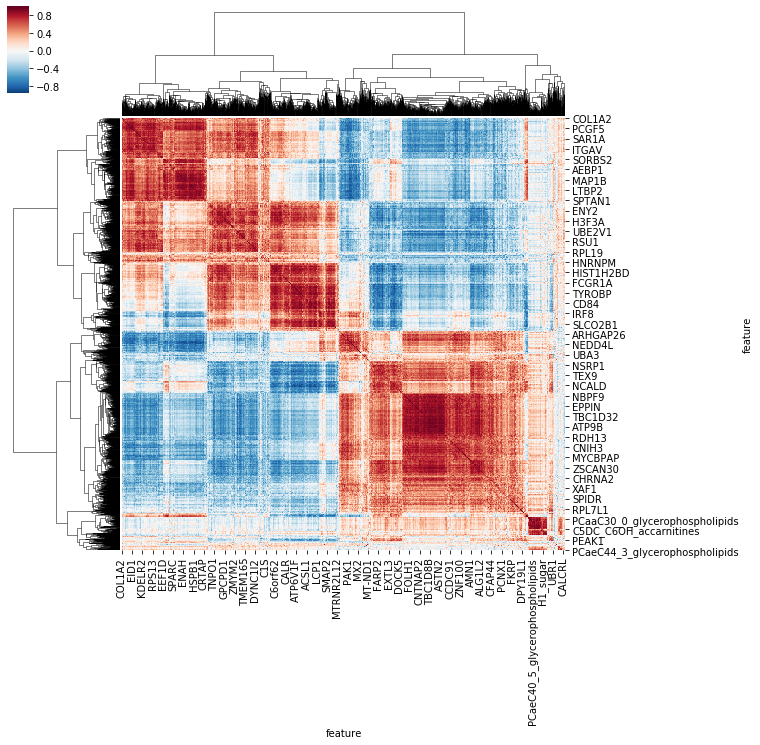

In [8]:
#Correlation and P val matrices
Rmatrix, Pmatrix= sp.stats.spearmanr(values.T)
Rmatrix=pd.DataFrame(Rmatrix, index=values.index.copy(), columns=values.index.copy())
sns.clustermap(Rmatrix, cmap="RdBu_r", center=0); #resulting R matrix, similar to that seen in the section above

If we look at the matrix of P values, we can already see that many of the correlations in the top right columns are not significant even before multiple hypothesis correction:

/usr/local/lib/python3.7/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


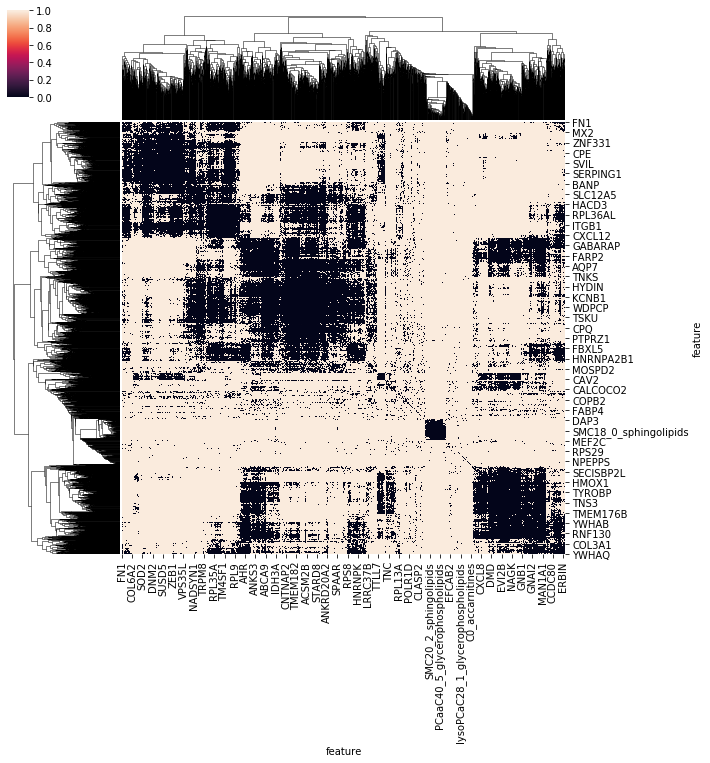

In [9]:
Pmatrix=pd.DataFrame(Pmatrix, index=values.index.copy(), columns=values.index.copy())
changed_Pmatrix=Pmatrix.copy()
changed_Pmatrix[changed_Pmatrix>0.01]=1
sns.clustermap(changed_Pmatrix); #resulting P matrix, similar to that seen in the section above

In [10]:
((2117**2)-2117)/2

2239786.0

We will now adjust the P values based on the number of comparisons done. The heatmaps above are highlighting a total of $2117^2 \approx 4.5m$ correlations. However, these numbers consider that the same correlation is computed twice (gene A vs gene B, and gene B vs gene A). If we were to include all correlations, we would thus be including many repeated analyses, and we are only interested in half of that above, and excluding the correlation of a feature with itself.   
This means $\frac{2117!}{2!(2117-2)!} \approx 2.2m$ correlations. At an error rate of 0.05, this means that the probability of finding at least one false positive is nearly 100%: $1-0.95^{2000000} \approx 1$. We thus need to correct P values. We will apply a Bonferroni correction as well as a FDR correction.

In [11]:
###Prepares R and P matrices
Psquared=Pmatrix.where(np.triu(np.ones(Pmatrix.shape),1).astype(np.bool))
Psquared.columns.name='Feat2'
Pmatrix=Pmatrix.stack()
Pmatrix.index.names=['v1','v2']
Pmatrix=Pmatrix.reset_index()
Pmatrix.columns=['feat1','feat2','P']



In [12]:
Rmatrix=Rmatrix.where(np.triu(np.ones(Rmatrix.shape),1).astype(np.bool))
Rmatrix.columns.name='Feat2'
Rmatrix=Rmatrix.stack()
Rmatrix.index.names=['v1','v2'] #Avoid stacked names colliding
Rmatrix=Rmatrix.reset_index()
Rmatrix.columns=['feat1','feat2','R']

PRmatrix=pd.merge(Rmatrix.copy(), Pmatrix.copy(), on=['feat1','feat2']) #Correlation matrix with both R and P
PRmatrix=PRmatrix.loc[PRmatrix.feat1!=PRmatrix.feat2].dropna()

In [13]:
#Multiple hypothesis correction computed on the P column
adjP=pd.DataFrame(multipletests(PRmatrix['P'], method='bonferroni', alpha=0.01)[1], columns=['Padj'])
FDR=pd.DataFrame(multipletests(PRmatrix['P'], method='fdr_bh', alpha=0.01)[1], columns=['FDR'])

PRmatrix=pd.concat([ PRmatrix, adjP], axis=1)
PRmatrix=pd.concat([ PRmatrix, FDR], axis=1)

PRmatrix.head()

feat1                   feat2         R         P  Padj       FDR
0  C0_accarnitines         C2_accarnitines  0.375326  0.070718   1.0  0.149290
1  C0_accarnitines         C3_accarnitines  0.519174  0.009329   1.0  0.033441
2  C0_accarnitines  C3DC_C4OH_accarnitines  0.395363  0.055848   1.0  0.125357
3  C0_accarnitines  C5DC_C6OH_accarnitines -0.029917  0.889631   1.0  0.928289
4  C0_accarnitines      C5MDC_accarnitines -0.137801  0.520795   1.0  0.643703

In [14]:
PRmatrix.shape[0]
#total number of correlations w/o repetition: 2.2m

2239786

Considering the Bonferroni correction we find 16305 correlations that are statistically significant at an $\alpha < 0.01$. If we consider instead FDR as correction method, we find 402368, which at a FDR of 0.01 implies $0.01 \times 402368 = 4023$ false positives.

In [15]:
sum(PRmatrix.Padj<0.01)

16305

In [16]:
sum(PRmatrix.FDR<0.01)

402368

Let's add two additional columns, where we assign `R=0` for those correlations that are not statistically significant (`adjusted P` or `FDR > 0.01`). 

In [17]:
PRmatrix.loc[:,'R (padj)']=PRmatrix['R'].copy()
PRmatrix.loc[:,'R (fdr)']=PRmatrix['R'].copy()
PRmatrix.loc[PRmatrix['Padj']>0.01,'R (padj)']=0
PRmatrix.loc[PRmatrix['FDR']>0.01,'R (fdr)']=0

all_mets=meta.loc[meta.Type=='met'].index
PRmatrix['feat1_type']=['met' if x in all_mets else 'gene' for x in PRmatrix.feat1 ]
PRmatrix['feat2_type']=['met' if x in all_mets else 'gene' for x in PRmatrix.feat2 ]
PRmatrix['int_type']=PRmatrix.feat1_type+'_'+PRmatrix.feat2_type
PRmatrix.to_csv('data/association_matrix.tsv', sep="\t", index=False)

Now we can see how the initial heatmap of correlations looks.

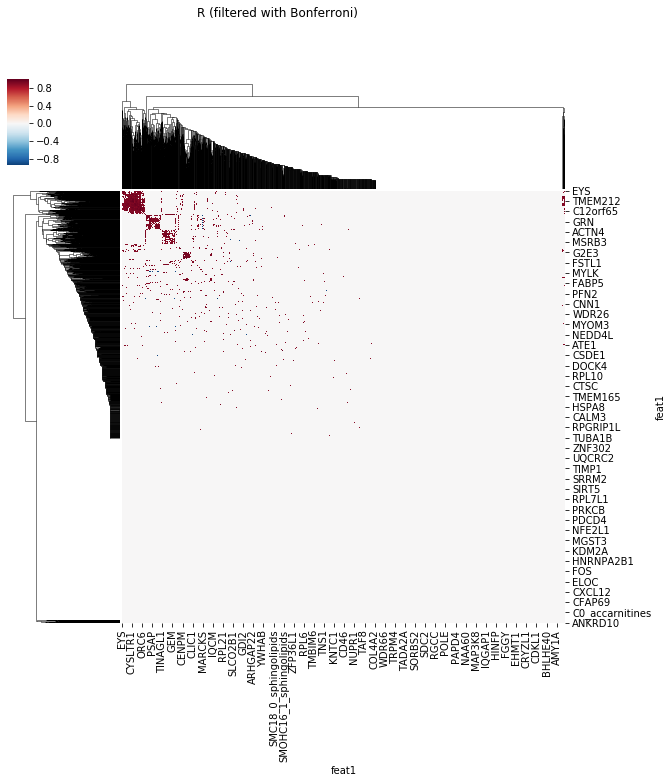

In [18]:
#Transforming to a squared matrix again
PRQ=pd.concat([
    PRmatrix.copy(), 
    PRmatrix.copy().rename(columns={'feat1':'feat2','feat2':'feat1'}).loc[:,PRmatrix.columns]
         ]).drop_duplicates()

Rmatrix_fdr=PRQ.copy().pivot(index='feat1',columns='feat2',values='R (fdr)')
Rmatrix_fdr=Rmatrix_fdr.loc[Rmatrix_fdr.sum()!=0]
Rmatrix_padj=PRQ.copy().pivot(index='feat1',columns='feat2',values='R (padj)')

Rmatrix_fdr=Rmatrix_fdr.loc[Rmatrix_fdr.index,Rmatrix_fdr.index].fillna(0)
Rmatrix_padj=Rmatrix_padj.loc[Rmatrix_fdr.index,Rmatrix_fdr.index].fillna(0)


#Showing only the top correlated features
top_features=((Rmatrix_fdr!=0).sum()>0.6*Rmatrix_fdr.shape[0]).index
Rmatrix_fdr=Rmatrix_fdr.loc[top_features,top_features]
Rmatrix_padj=Rmatrix_padj.loc[top_features,top_features]

g=sns.clustermap(Rmatrix_padj, cmap="RdBu_r", center=0);
g.fig.suptitle('R (filtered with Bonferroni)');
plt.show()

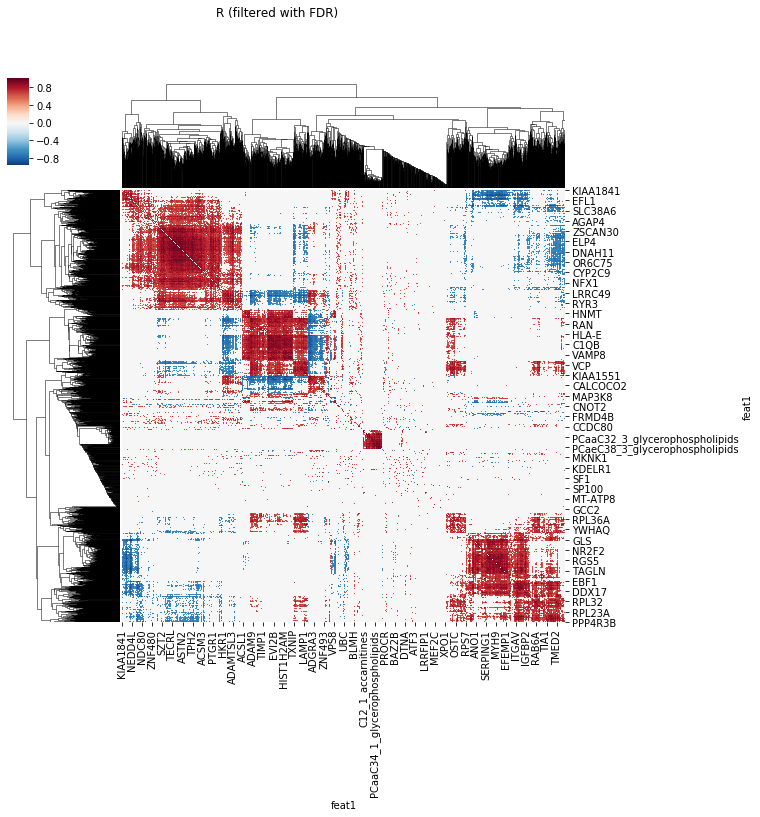

In [19]:
g=sns.clustermap(Rmatrix_fdr, cmap="RdBu_r", center=0);
g.fig.suptitle('R (filtered with FDR)');
plt.show()

The plots above show that the Bonferroni correction is only selecting very high (absolute) correlations. This may remove false positives, but it may also remove slightly weaker correlations that are biologically relevant. The Bonferroni correction also removes most of the negatively-associated features. Notice this from the distribution of correlation coefficients:

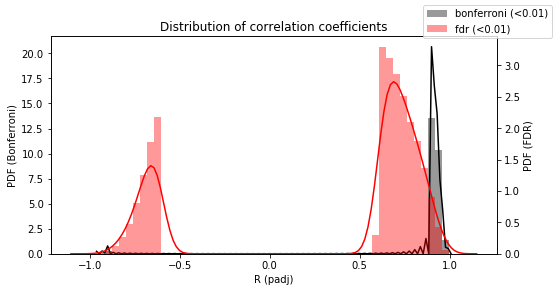

In [20]:
shortPR=PRmatrix.copy().loc[:,['feat1','feat2','R (padj)','R (fdr)']]
shortPR=shortPR.loc[shortPR.feat1!=shortPR.feat2]

fig=plt.figure(figsize=(8,4))
p=sns.distplot(shortPR['R (padj)'][shortPR['R (padj)']!=0], color='black');
p.set(ylabel='PDF (Bonferroni)')
ax2=p.twinx()
g=sns.distplot(shortPR['R (fdr)'][shortPR['R (fdr)']!=0], ax=ax2, color='r');
g.set(ylabel='PDF (FDR)')

fig.legend(labels=['bonferroni (<0.01)','fdr (<0.01)']);
plt.xlabel('R')
plt.title('Distribution of correlation coefficients')
plt.show()

We can also observe that the Bonferroni correction yields a more homogeneous number of associated features for each feature (i.e. first neighbors), compared to the FDR filtering. Notice how for a subset of features many correlations are identified (>200).

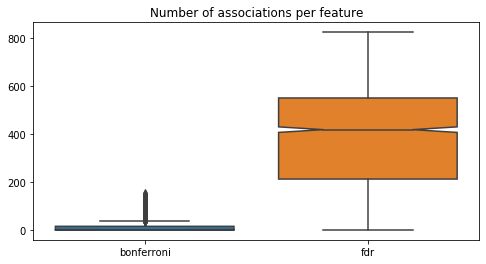

In [21]:
feat_associations_padj=pd.concat([
    shortPR.copy().loc[shortPR['R (padj)']!=0,][['feat1','feat2']],
    shortPR.copy().loc[shortPR['R (padj)']!=0,][['feat2','feat1']].rename(columns={'feat1':'feat2','feat2':'feat1'})]).drop_duplicates().groupby('feat1').agg('count')

feat_associations_fdr=pd.concat([
    shortPR.copy().loc[shortPR['R (fdr)']!=0,][['feat1','feat2']],
    shortPR.copy().loc[shortPR['R (fdr)']!=0,][['feat2','feat1']].rename(columns={'feat1':'feat2','feat2':'feat1'})]).drop_duplicates().groupby('feat1').agg('count')

feat_associations=pd.concat([feat_associations_padj, feat_associations_fdr],1, sort=True)
feat_associations.fillna(0,inplace=True)
feat_associations.columns=['bonferroni','fdr']

fig=plt.figure(figsize=(8,4))
sns.boxplot( data=feat_associations, notch=True);
plt.title('Number of associations per feature')
plt.show()

Most of the statistically significant correlations are only identified within each omic.

In [22]:
bonferroni_significant=PRmatrix.copy().loc[PRmatrix.Padj<0.01].loc[:,['feat1','feat2','R','int_type']]
bonferroni_significant['sig_test']='bonferroni'
fdr_significant=PRmatrix.copy().loc[PRmatrix.FDR<0.01].loc[:,['feat1','feat2','R','int_type']]
fdr_significant['sig_test']='FDR'

pd.concat([bonferroni_significant,fdr_significant]).groupby(['sig_test','int_type'])['R'].agg('count').reset_index()

sig_test   int_type       R
0         FDR  gene_gene  398274
1         FDR   met_gene     118
2         FDR    met_met    3976
3  bonferroni  gene_gene   15434
4  bonferroni    met_met     871

### Questions

In building a graph from an association analysis:
- Why do you think that most significant correlations are found only within each omic? 
- How will you deal with the positive and negative sets of correlations above?
- Will you consider the network as weighted? Directed?
- Which dataset would you select for further analysis: the Bonferroni or the FDR-corrected? Why?
- What preliminary tests would you perform on the graph to assess whether node relationships are random?

In [23]:
#saves the dataframe
PRmatrix.to_csv('data/association_matrix.tsv', sep="\t", index=False)

# Network construction and preliminary analysis

We will now build 2 different networks to analyse further:
- A full association network filtered using FDR-corrected P values (<0.01). This is an unweighted network.
- The subset of positively associated features, where correlation coefficient is used as weight.
- k-NNG that we will generate from the expression profile. This will be unweighted.
- A random network based on the [Erdos-Renyi model](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model), with the same node and edge number as the first (full) network. This will be a null-model for our analyses. The idea is that if a certain property found in one of our graphs is  reproduced in a random graph, then we do not need to account for any other possible explanations for that feature. In other words, if a property of a graph (e.g. clustering) is not found in a random network, we can assume that it does not appear in our biological network due to randomness.

In [24]:
# Prepares table for being read by igraph
PRmatrix=pd.read_csv('data/association_matrix.tsv', sep="\t")
PRmatrix.loc[PRmatrix['FDR']>0.01,'R (fdr)']=0
PRmatrix=PRmatrix.loc[PRmatrix['R (fdr)']!=0,['feat1','feat2','R (fdr)']]
PRmatrix=PRmatrix.loc[PRmatrix.feat1!=PRmatrix.feat2] #drops self correlations

fdr_pos_mat=PRmatrix.loc[PRmatrix['R (fdr)']>0]
fdr_neg_mat=PRmatrix.loc[PRmatrix['R (fdr)']<0]

PRmatrix=PRmatrix.loc[PRmatrix.isin(pd.unique(fdr_pos_mat[['feat1','feat2']].values.flatten())).sum(1)==2,] #selects only nodes also found in the positive network so that we can compare networks of the same sizes

We will now build the k-NNG, using distances as input to determine the nearest neighbours. Because this data contains both gene expressions and metabolite quantifications, we need to normalize them beforehand. (We didn't need to do this above as we were comparing ranks)

We'll normalize all features so that they range between 0 and 1.

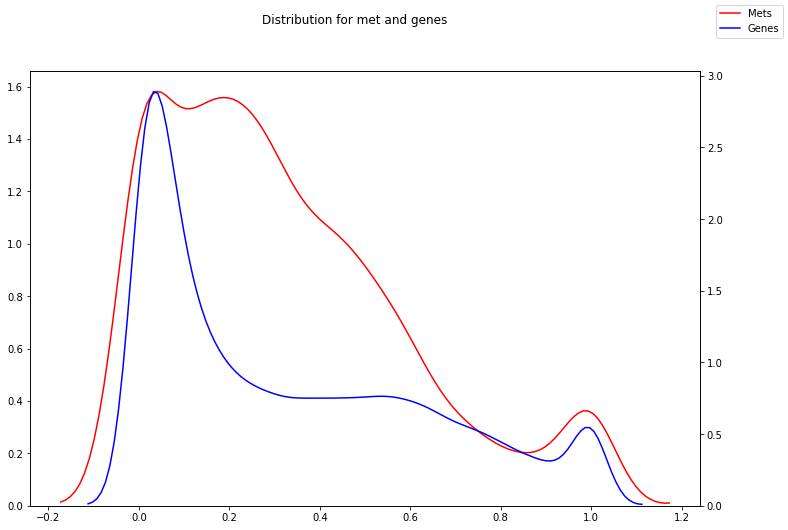

In [25]:
#Imports and normalizes met and gene data so that we can compute similarities between them
from sklearn.preprocessing import MinMaxScaler
data=pd.read_csv('data/met_genes.tsv', sep="\t", index_col=0)

scaled_data=pd.DataFrame(MinMaxScaler().fit_transform(data.loc[:,data.columns!='Type'].T).T, columns=data.columns[data.columns!='Type'], index=data.index)
scaled_data_values=scaled_data.copy()
scaled_data['Type']=data.Type

#Plots the data distribution
fig,ax=plt.subplots(figsize=(12,8))
sns.kdeplot(
    scaled_data.loc[scaled_data.Type=='met',scaled_data.columns!='Type'].values.flatten(), 
    color='r', label='Mets', ax=ax, legend=False)
ax2=ax.twinx()
sns.kdeplot(
    scaled_data.loc[scaled_data.Type=='genes',scaled_data.columns!='Type'].values.flatten(),
    color='b', label='Genes', ax=ax2, legend=False)
fig.suptitle('Distribution for met and genes');
fig.legend();

We will now generate the graphs from the dataframes above

In [26]:
### Generating the kNN graph
#Computes a kNN adjacency matrix from the input dataset
#and prepares table for being read by igraph
input_ds=scaled_data_values.loc[scaled_data_values.index.isin(pd.unique(fdr_pos_mat[['feat1','feat2']].values.flatten()))]
knnG=sklearn.neighbors.kneighbors_graph(input_ds.values, 50, metric='euclidean')
knnG=pd.DataFrame(knnG.toarray(), columns=input_ds.index.copy(), index=input_ds.index.copy())  #adjacency matrix
knnG.index.name='gene1'
knnG.columns.name='gene2'
knnG=knnG.stack().reset_index().rename(columns={0:'Connectivity'})
knnG=knnG.loc[knnG['Connectivity']!=0]

### Generates each of the graphs
#positive associations, weighted
pos_w=ig.Graph.TupleList([tuple(x) for x in fdr_pos_mat.values], directed=False, edge_attrs=['w'])

#full network, unweighted
all_u=ig.Graph.TupleList([tuple(x) for x in PRmatrix.loc[PRmatrix.isin(pd.unique(fdr_pos_mat[['feat1','feat2']].values.flatten())).sum(1)==2,['feat1','feat2']].values], directed=False)

#knnG, unweighted
knn=ig.Graph.TupleList([tuple(x) for x in knnG.values], directed=False)

#random network, unweighted, node and edge number based on a network of the same size
randomG=ig.Graph.Erdos_Renyi(
    n=2102, 
    m=len(fdr_pos_mat.values), directed=False, loops=False)

For representation purposes we will see how a short knn graph looks - be careful in drawing the others, as they have many more edges it becomes computationally heavy.

In [27]:
#random subset of knn graph for plotting
short_knn=ig.Graph.TupleList([tuple(x) for x in knnG.values[random.sample(list(np.arange(len(knnG.values))), 10000)]], directed=False)

#This plots each graph, using degree to present node size:
short_knn.vs['degree']=short_knn.degree() 
short_knn.vs['degree_size']=[(x*15)/(max(short_knn.vs['degree'])) for x in short_knn.vs['degree']] #degree is multiplied by 10 so that we can see all nodes

layout = short_knn.layout_mds()
ig.plot(short_knn, layout=layout, vertex_color='white', edge_color='silver', vertex_size=short_knn.vs['degree_size'])

In the next table, we can see that while the same number of nodes is found in all networks, the number of edges varies greatly. We also see that the network is fully connected, which is not allways the case. If it wasn't connected, we could select the ***k***  largest connected components, and proceed the analyses with them. The largest connected component is called the *giant component*.

In [28]:
#function to get graph properties, takes a few minutes to run
def graph_prop(input_graph):
    ncount=nn.vcount()
    ecount=nn.ecount()
    diameter=nn.diameter()
    av_path=nn.average_path_length()
    dens=nn.density()
    clustering=nn.transitivity_undirected() #this is the global clustering coefficient
    conn=nn.is_connected()
    min_cut=nn.mincut_value()
    out=pd.DataFrame([ncount, ecount, diameter, av_path, dens, clustering, conn, min_cut],
                 index=['node_count','edge_count','diameter','av_path_length','density','clustering_coef','connected?','minimum_cut']).T
    return(out)

#summarizing graph properties
network_stats=pd.DataFrame()
for nn in [pos_w, all_u, knn, randomG]:
    network_stats=pd.concat([network_stats,graph_prop(nn)])
    
network_stats.index=['pos_w','all_u','knn','random']
network_stats

node_count edge_count diameter av_path_length    density  \
pos_w        2102     293544        8        2.93304   0.132937   
all_u        2102     402360        7        2.11979   0.182216   
knn          2102     105100        7        3.47042  0.0475964   
random       2102     293544        2        1.86706   0.132937   

       clustering_coef connected? minimum_cut  
pos_w          0.71453      False           0  
all_u         0.610098      False           0  
knn           0.457175       True          50  
random        0.133025       True         228

### Questions:
- Why is the diameter and average path length lower in the case of the full network and the random network, compared to the other two networks?
- Why do you think the clustering coefficient is lower for the knn compared with the other networks?
- Why is the minimum cut much larger in the random network compared to the others?
- Do you agree with the *k* selected for the kNN-g?

# Centrality analysis

We'll look into different centrality measures:
- [Degree](https://en.wikipedia.org/wiki/Degree_(graph_theory)) - number of neighbors of a node
- [Betweenness](https://en.wikipedia.org/wiki/Betweenness_centrality) - measures how many shortest paths in the network pass through a node.
- [Closeness](https://en.wikipedia.org/wiki/Centrality#Closeness_centrality) - the average length of the shortest paths between a node and all other nodes 
- [Eccentricity](https://en.wikipedia.org/wiki/Distance_(graph_theory)) - largest shortest path from a node to any other node. Nodes with high eccentricity tend to be on the periphery.

Degree, Betweenness and Closeness are additionally computed for the positive association network by taking into account each edge's weight. For instance, for degree this is done for each node by summing each edge's degree. 

Because the number of shortest paths in a network scales with the network size, we normalize Eccentricity and Betweenness with respect to the network size so that they can be compared between the four networks above.

**Degree distribution**  
Let's start by comparing the degrees of the random network against the three other networks. From the figures below it seems that there is no relationship between the degree of the random network, and any of the three others.

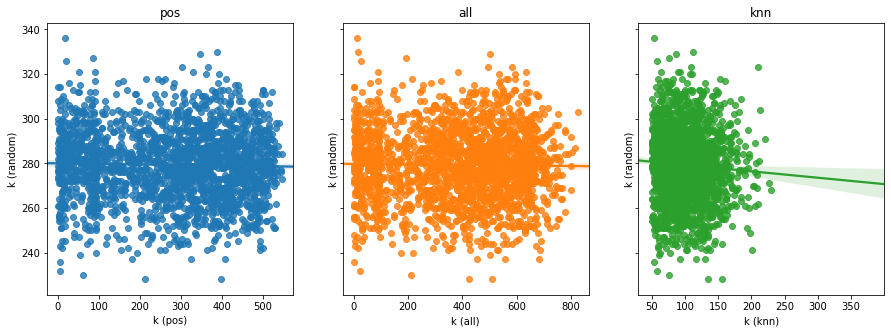

In [29]:
fig, axes=plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey='row')

for i, ax in zip(range(4), axes.flat):
    sns.regplot([pos_w,all_u,knn][i].degree(), randomG.degree(), ax=ax);
    ax.set_title(['pos','all','knn'][i])
    ax.set(xlabel='k ('+['pos','all','knn'][i]+')', ylabel='k (random)')


In [30]:
def transform_degree(graph):
    alldegs=graph.degree()
    alldegs=pd.DataFrame([[key,len(list(group))] for key,group in itertools.groupby(alldegs)], columns=['k','count'])
    alldegs['P(k)']=[x/alldegs['count'].sum() for x in alldegs['count']]
    alldegs=alldegs.loc[:,['k','P(k)']]
    alldegs.drop_duplicates(inplace=True)
    alldegs.reset_index(drop=True, inplace=True)
    return(alldegs)

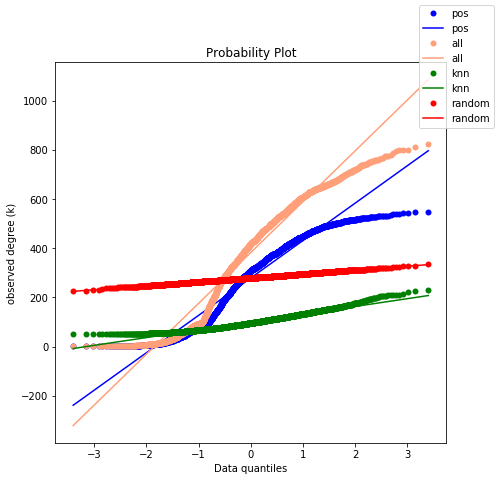

In [31]:
fig, ax = plt.subplots(figsize=(7, 7))
# ax.set(yscale='log', xscale='log')
p=sp.stats.probplot(pos_w.degree(), plot=ax)
a=sp.stats.probplot(all_u.degree(), plot=ax)
k=sp.stats.probplot(knn.degree(), plot=ax)
r=sp.stats.probplot(randomG.degree(), plot=ax)

col=['blue','','lightsalmon','','green','','red']
for x in np.arange(0,7,2):
    ax.get_lines()[x].set_markerfacecolor(col[x])
    ax.get_lines()[x].set_markeredgewidth(0)
    ax.get_lines()[x+1].set_color(col[x])


fig.legend(labels=['pos','pos','all','all','knn','knn','random','random']);

ax.set(xlabel='Data quantiles', ylabel='observed degree (k)')
plt.show()

**Centrality**  
We will now compare different centrality metrics between the graphs.

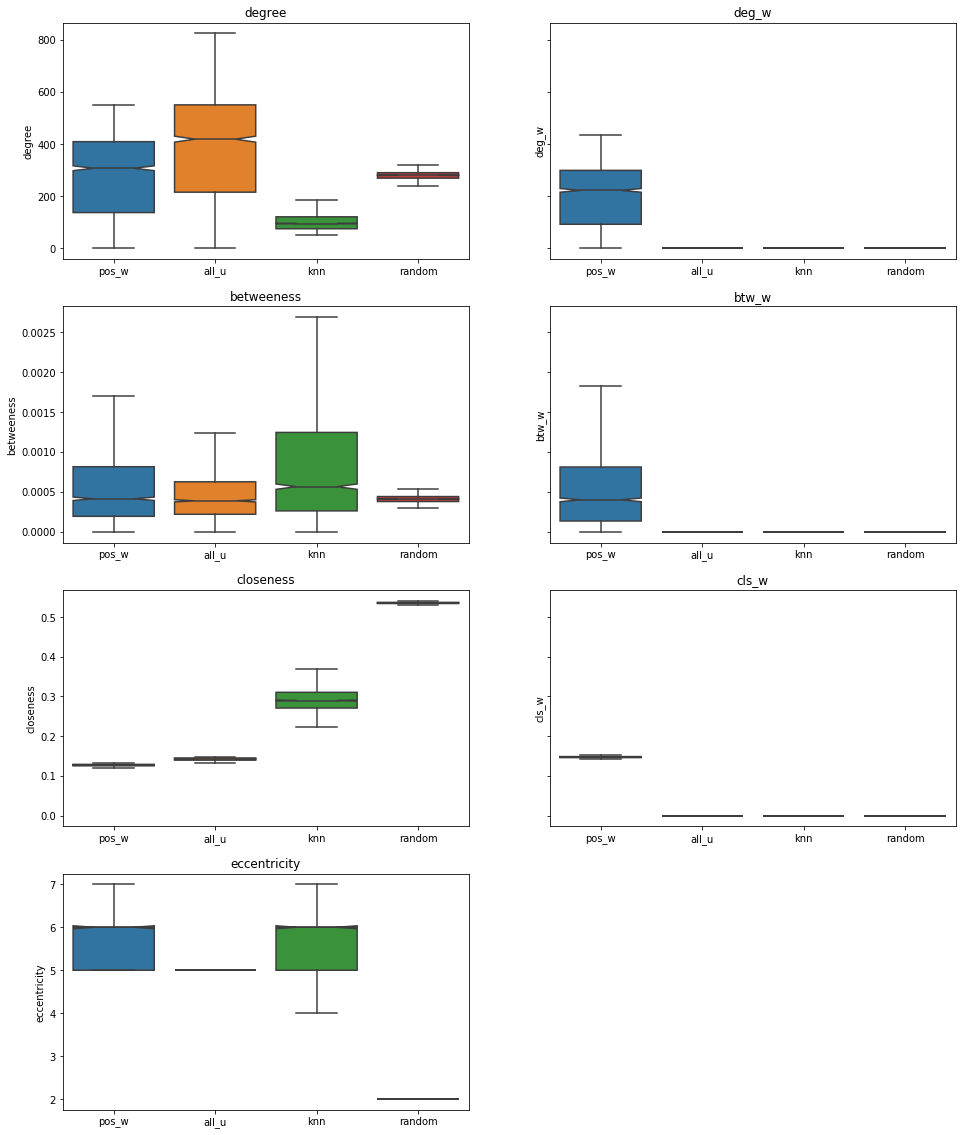

In [32]:
### This function computes different centrality measures
def combine_raw_centralities():
    def centrality_raw(input_graph, graph_name):
        deg=input_graph.degree()
        ecc=input_graph.eccentricity()
        node_n=input_graph.vcount()
        btw=[(2*x / ((node_n-1)*(node_n-2))) for x in input_graph.betweenness(directed=False)] #scaled to account for network size
        cls=input_graph.closeness(normalized=True)

        #if edge weight is defined, compute weighted centralities
        #otherwise, return a vector of 0
        if('w' in input_graph.es.attribute_names()): 
            deg_w=input_graph.strength(weights='w')    #this is a weighted degree
            btw_w=[(2*x / ((node_n-1)*(node_n-2))) for x in input_graph.betweenness(directed=False, weights='w')]
            cls_w=input_graph.closeness(weights='w', normalized=True)
        else:
            btw_w=np.repeat(0,input_graph.vcount())
            deg_w=np.repeat(0,input_graph.vcount())
            cls_w=np.repeat(0,input_graph.vcount())

        out=pd.DataFrame(
            [deg, ecc, btw, cls, deg_w, btw_w, cls_w],
            index=['degree','eccentricity','betweeness', 'closeness',
                   'deg_w','btw_w','cls_w']).T
        out['graph']=graph_name
        out=out.loc[:,np.append(['graph'],out.columns[out.columns!='graph'])]
        
        ##Adds centralities for each node in the network
        input_graph.vs['degree']=out.degree
        input_graph.vs['eccentricity']=out.eccentricity
        input_graph.vs['betweeness']=out.betweeness
        input_graph.vs['closeness']=out.closeness
        input_graph.vs['deg_w']=out.deg_w
        input_graph.vs['btw_w']=out.btw_w
        input_graph.vs['cls_w']=out.cls_w
        
        return(out)
    
    #Computes centralities for all networks
    network_centralities_raw=pd.DataFrame()
    network_centralities_raw=pd.concat([network_centralities_raw,centrality_raw(pos_w,'pos_w')])
    network_centralities_raw=pd.concat([network_centralities_raw,centrality_raw(all_u,'all_u')])
    network_centralities_raw=pd.concat([network_centralities_raw,centrality_raw(knn,'knn')])
    network_centralities_raw=pd.concat([network_centralities_raw,centrality_raw(randomG,'random')])
    return(network_centralities_raw)

network_centralities_raw=combine_raw_centralities()

fig, axes=plt.subplots(nrows=4, ncols=2, figsize=(16,20), sharey='row')
cen=['degree','deg_w','betweeness', 'btw_w', 'closeness','cls_w','eccentricity']
for i, ax in zip(range(10), axes.flat):
    if(i==7):
        fig.delaxes(ax)
        break
    sns.boxplot(data=network_centralities_raw, x='graph', y=cen[i],  #outliers are hidden from plotting
                notch=True, ax=ax, showfliers=False)
    ax.set_title(cen[i])
    ax.set(xlabel='')

Overall, we see:
- The median degree centrality decreases from `Full network > Positive assoc. network > kNN-G`.
- The median betweenness centrality tends to decrease from `kNN-G > Full network ~ Positive assoc. network`.
- The median closeness centrality  tends to decrease from `kNN-G > Full network > Positive assoc. network`.
- The eccentricity is homogeneous for the `Positive assoc. network` and for the `Full network`, but nodes in the latter tend to display higher eccentricity. In turn, most nodes in the `kNN-G` tend to display an eccentricity of 5-6.

### Questions:
- Can you explain these observations?
- Based on the plots above, which graphs do you think follow a [*small world*](https://en.wikipedia.org/wiki/Small-world_network) behavior?

We then examine genes and metabolites for each graph:

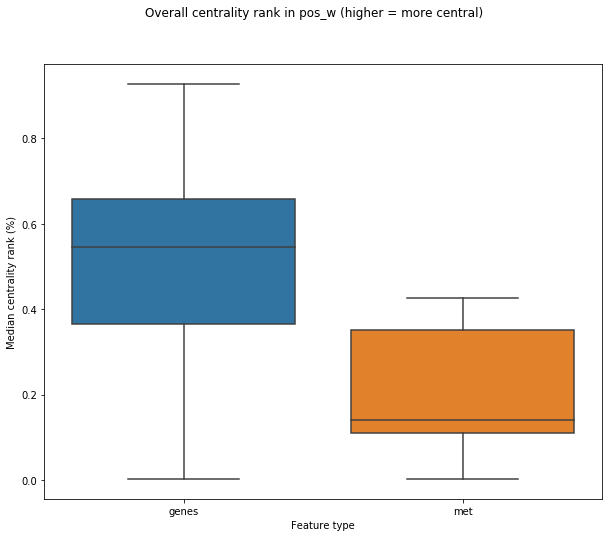

In [33]:
full_centralities=pd.DataFrame()
for net in [0,1,2]:
    net_in=[pos_w, all_u, knn, randomG][net]
    net_nm=['pos_w', 'all_u', 'knn'][net]
    temp=pd.DataFrame([net_in.vs[att] for att in ['name','degree','betweeness', 'closeness','eccentricity']], index=['name','degree','betweeness', 'closeness','eccentricity']).T
    temp.columns=[x+'|'+net_nm for x in temp.columns]
    temp.rename(columns={'name|'+net_nm:'name'}, inplace=True)
    temp.loc[:,temp.columns!='name']=temp.loc[:,temp.columns!='name'].rank(pct=True)
    temp['median_centrality|'+net_nm]=temp.loc[:,temp.columns!='name'].median(1)
    if(net==0):
        full_centralities=temp
    else:
        full_centralities=pd.merge(full_centralities, temp, on='name')
full_centralities.set_index('name', inplace=True)
full_centralities=pd.merge(full_centralities, data[['Type']], left_index=True, right_index=True, how='left')
full_centralities['median|ALL']=full_centralities.loc[:,full_centralities.columns.str.contains('median')].median(1)
full_centralities.sort_values('median_centrality|pos_w',ascending=False,inplace=True)

fig,ax=plt.subplots(figsize=(10,8))
sns.boxplot(data=full_centralities, x='Type', y='median_centrality|pos_w')
ax.set(xlabel='Feature type', ylabel='Median centrality rank (%)');
fig.suptitle('Overall centrality rank in pos_w (higher = more central)');

This shows that genes, in general, tend to be more central in all networks. We can get the 10 most central metabolites and genes:

In [34]:
full_centralities.loc[full_centralities.Type=='met',full_centralities.columns.str.contains('pos_w|ALL')].head(10)

degree|pos_w betweeness|pos_w closeness|pos_w  \
name                                                                           
C16_accarnitines                   0.141532          0.71313      0.00856327   
PCaeC40_3_glycerophospholipids       0.2098         0.647479        0.067079   
PCaeC42_2_glycerophospholipids     0.208373         0.624167       0.0666032   
PCaeC36_1_glycerophospholipids     0.206708         0.617507       0.0642245   
PCaeC38_4_glycerophospholipids     0.203378         0.950048       0.0884872   
PCaeC36_2_glycerophospholipids     0.203378         0.796384       0.0746908   
PCaaC30_0_glycerophospholipids     0.203378         0.952426       0.0875357   
PCaaC36_3_glycerophospholipids     0.206708         0.613701       0.0661275   
PCaaC32_0_glycerophospholipids     0.199096         0.947193        0.100381   
PCaeC32_2_glycerophospholipids     0.190771         0.940057       0.0908658   

                               eccentricity|pos_w  median_centrality|pos_w  \
name                                                                         
C16_accarnitines                         0.980019                 0.427331   
PCaeC40_3_glycerophospholipids           0.617269                 0.413535   
PCaeC42_2_glycerophospholipids           0.617269                 0.412821   
PCaeC36_1_glycerophospholipids           0.617269                 0.411989   
PCaeC38_4_glycerophospholipids           0.617269                 0.410324   
PCaeC36_2_glycerophospholipids           0.617269                 0.410324   
PCaaC30_0_glycerophospholipids           0.617269                 0.410324   
PCaaC36_3_glycerophospholipids           0.617269                 0.410205   
PCaaC32_0_glycerophospholipids           0.617269                 0.408183   
PCaeC32_2_glycerophospholipids           0.617269                 0.404020   

                                median|ALL  
name                                        
C16_accarnitines                  0.401284  
PCaeC40_3_glycerophospholipids    0.413535  
PCaeC42_2_glycerophospholipids    0.286751  
PCaeC36_1_glycerophospholipids    0.411989  
PCaeC38_4_glycerophospholipids    0.362155  
PCaeC36_2_glycerophospholipids    0.410324  
PCaaC30_0_glycerophospholipids    0.410324  
PCaaC36_3_glycerophospholipids    0.410205  
PCaaC32_0_glycerophospholipids    0.408183  
PCaeC32_2_glycerophospholipids    0.404020

In [35]:
full_centralities.loc[full_centralities.Type=='genes',full_centralities.columns.str.contains('pos_w|ALL')].head(10)

degree|pos_w betweeness|pos_w closeness|pos_w eccentricity|pos_w  \
name                                                                       
GNAI2       0.927926         0.928639        0.981208           0.617269   
NUDT9       0.921265         0.930542          0.9353           0.617269   
RAB10       0.902474         0.910561        0.978592           0.617269   
FCRL5       0.936013         0.917697        0.887964           0.138202   
S100A11     0.857755         0.939581        0.998573           0.617269   
ACTR3       0.848002         0.941009        0.997859           0.617269   
PARP15      0.898906         0.925785        0.881779           0.138202   
DLGAP1      0.786156         0.990485        0.993815           0.617269   
CDV3        0.841817         0.934824         0.99667           0.617269   
CALM1        0.90509         0.887726        0.882731           0.138202   

         median_centrality|pos_w  median|ALL  
name                                          
GNAI2                   0.928283    0.816246  
NUDT9                   0.925904    0.921147  
RAB10                   0.906518    0.906518  
FCRL5                   0.902831    0.886537  
S100A11                 0.898668    0.898668  
ACTR3                   0.894505    0.831232  
PARP15                  0.890343    0.890343  
DLGAP1                  0.888321    0.888321  
CDV3                    0.888321    0.878806  
CALM1                   0.885228    0.872621

### Questions:
- Can you explain the differences in centrality between genes and metabolites?
- Can you explain why a gene with a very high degree can have a low eccentricity?

# Community detection

To identify communities, we will use the [Leiden algorithm](https://github.com/vtraag/leidenalg). This method is similar to the [Louvain method](https://en.wikipedia.org/wiki/Louvain_modularity) but fixes different intrinsic problems it has.

In [36]:
partition = leidenalg.find_partition(short_knn, leidenalg.ModularityVertexPartition)
layout = short_knn.layout_mds()
ig.plot(partition, layout=layout, edge_color='silver', vertex_size=short_knn.vs['degree_size'])

We will perform the community analysis on the 4 networks. We will perform one additional community analysis by considering the edge weights from the positively associated network. Importantly, this method searches for the largest possible communities for our network, which may not always be the desired. Alternative models such as the [Constant Potts Model](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.84.016114) allow you to identify smaller communities. Should we know that our data has special feature classes, we can compare whether the communities identify those classes by examining them individually, and increasing the resolution if needed.

In [38]:
pos_comm = leidenalg.find_partition(pos_w, leidenalg.ModularityVertexPartition)
pos_w_comm = leidenalg.find_partition(pos_w, leidenalg.ModularityVertexPartition, weights='w')
all_comm = leidenalg.find_partition(all_u, leidenalg.ModularityVertexPartition)
knn_comm = leidenalg.find_partition(knn, leidenalg.ModularityVertexPartition)
random_comm = leidenalg.find_partition(randomG, leidenalg.ModularityVertexPartition)

Predictably, we can see that the modularity score of any of the networks is substantially larger than that of the random network.

In [39]:
np.round(pos_comm.modularity,3)

0.59

In [40]:
np.round(pos_w_comm.modularity,3)

0.588

In [41]:
np.round(all_comm.modularity,3)

0.427

In [42]:
np.round(knn_comm.modularity,3)

0.711

In [43]:
np.round(random_comm.modularity,3)

0.04

Comparing the different communities by size:

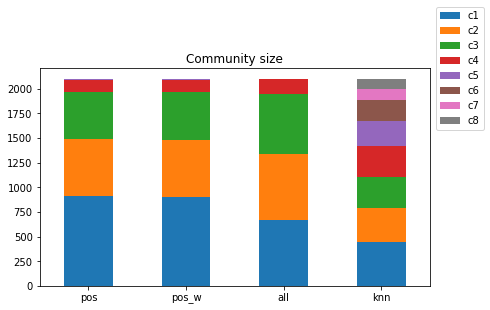

In [44]:
#Compiles feat lists per community
def get_community_table():
    comm_counts=pd.DataFrame()
    feat_lists=pd.DataFrame()
    for i in [0,1,2,3]:
        graph=[pos_w,pos_w,all_u,knn][i]
        comm=[pos_comm,pos_w_comm,all_comm,knn_comm][i]
        name=['pos','pos_w','all','knn'][i]
        temp=pd.DataFrame(list(zip(graph.vs['name'],[x+1 for x in comm.membership]))).rename(columns={0:'feat',1:'community'})
        counts=pd.DataFrame(temp.groupby('community')['feat'].agg(len))
        counts.columns=[name]
        comm_counts=pd.concat([comm_counts, counts],1)
        
        gl=pd.DataFrame(temp.groupby('community')['feat'].apply(list)).reset_index()
        gl['community']=['c'+str(i) for i in gl['community']]
        gl['network']=name
        gl=gl.loc[:,['network','community','feat']]
        feat_lists=pd.concat([feat_lists, gl])
        
    comm_counts.index=['c'+str(i) for i in comm_counts.index]
    return([comm_counts,feat_lists])

#Plotting community sizes
import seaborn as sns
fig, ax = plt.subplots(figsize=(7, 4))
get_community_table()[0].fillna(0).T.plot(kind='bar', stacked=True, ax=ax);
ax.legend(get_community_table()[0].index, loc='right', bbox_to_anchor=(1.15, 1));
ax.set_title('Community size')
plt.xticks(rotation=0)
plt.show()

Can you explain why the KNN network has so many more communities than the others?

**Functional analysis**  
In order to perform functional enrichment, we will extract each of the communities and perform a hypergeometric test **on the genes** to understand whether they are particularly enriched in specific biological functions.  
We will use [enrichr](https://gseapy.readthedocs.io/en/master/gseapy_example.html#2.-Enrichr-Example) to perform the gene set enrichment analysis. As background we will use the full list of genes that were quantified.

We will look at 3 gene set libraries. Should you have other kinds of data, enrichr allows you to define your own feature sets and perform a similar analysis. The challenge is in identifying comprehensive and well curated gene sets.

In [45]:
#All the available human libraries
gp.get_library_name(database='Human')[:15]

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019']

In [46]:
#we will search 3 libraries for significantly enriched gene sets
gene_sets=['GO_Biological_Process_2018','KEGG_2019_Human','OMIM_Disease']
background=[x for x in all_u.copy().vs['name'] if x in data.loc[data.Type=='genes'].index]
all_genes=data.loc[data.Type=='genes'].index

def perform_enrich(network):
    temp=get_community_table()[1].copy()
    temp=temp.loc[temp['network']==network]
    output_enrichr=pd.DataFrame()
    for comm in temp['community'].values:
        gl=list(temp.loc[temp['community']==comm, 'feat'])[0]
        gl=list([x for x in gl if x in all_genes])
        if(len(gl)<30):
            continue
        print('Found '+str(len(gl))+'genes in community.')
        for bp in gene_sets:
            print('Analyzing '+network+' network | Comm: '+comm+'/'+str(len(temp.index))+'  | BP: '+bp)
            enr=gp.enrichr(
                gene_list=gl,
                gene_sets=bp,
                background=background,
                outdir='data/Enrichr',
                format='png'
            )

            results=enr.results.sort_values('Adjusted P-value', ascending=True)
            results=results.loc[results['Adjusted P-value']<0.05,]
            results['BP']=bp
            results['Comm']=comm
            results['Graph']=network
            output_enrichr=pd.concat([output_enrichr, results])
            
    return(output_enrichr)

all_enriched=pd.DataFrame()
for net in ['pos', 'pos_w', 'all', 'knn']: 
    all_enriched=pd.concat([all_enriched,perform_enrich(net)])

Found 905genes in community.
Analyzing pos network | Comm: c1/7  | BP: GO_Biological_Process_2018


2020-02-13 15:57:09,715 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


Analyzing pos network | Comm: c1/7  | BP: KEGG_2019_Human


2020-02-13 15:57:13,314 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


Analyzing pos network | Comm: c1/7  | BP: OMIM_Disease


2020-02-13 15:57:16,801 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 579genes in community.
Analyzing pos network | Comm: c2/7  | BP: GO_Biological_Process_2018
Analyzing pos network | Comm: c2/7  | BP: KEGG_2019_Human
Analyzing pos network | Comm: c2/7  | BP: OMIM_Disease
Found 480genes in community.
Analyzing pos network | Comm: c3/7  | BP: GO_Biological_Process_2018
Analyzing pos network | Comm: c3/7  | BP: KEGG_2019_Human
Analyzing pos network | Comm: c3/7  | BP: OMIM_Disease


2020-02-13 15:57:50,362 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 901genes in community.
Analyzing pos_w network | Comm: c1/7  | BP: GO_Biological_Process_2018


2020-02-13 15:57:54,827 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


Analyzing pos_w network | Comm: c1/7  | BP: KEGG_2019_Human


2020-02-13 15:57:58,400 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


Analyzing pos_w network | Comm: c1/7  | BP: OMIM_Disease


2020-02-13 15:58:01,886 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 578genes in community.
Analyzing pos_w network | Comm: c2/7  | BP: GO_Biological_Process_2018
Analyzing pos_w network | Comm: c2/7  | BP: KEGG_2019_Human
Analyzing pos_w network | Comm: c2/7  | BP: OMIM_Disease


2020-02-13 15:58:17,496 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 484genes in community.
Analyzing pos_w network | Comm: c3/7  | BP: GO_Biological_Process_2018
Analyzing pos_w network | Comm: c3/7  | BP: KEGG_2019_Human
Analyzing pos_w network | Comm: c3/7  | BP: OMIM_Disease
Found 668genes in community.
Analyzing all network | Comm: c1/6  | BP: GO_Biological_Process_2018
Analyzing all network | Comm: c1/6  | BP: KEGG_2019_Human
Analyzing all network | Comm: c1/6  | BP: OMIM_Disease


2020-02-13 15:58:50,998 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 659genes in community.
Analyzing all network | Comm: c2/6  | BP: GO_Biological_Process_2018
Analyzing all network | Comm: c2/6  | BP: KEGG_2019_Human
Analyzing all network | Comm: c2/6  | BP: OMIM_Disease
Found 611genes in community.
Analyzing all network | Comm: c3/6  | BP: GO_Biological_Process_2018
Analyzing all network | Comm: c3/6  | BP: KEGG_2019_Human
Analyzing all network | Comm: c3/6  | BP: OMIM_Disease


2020-02-13 15:59:23,882 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 43genes in community.
Analyzing all network | Comm: c4/6  | BP: GO_Biological_Process_2018
Analyzing all network | Comm: c4/6  | BP: KEGG_2019_Human


2020-02-13 15:59:32,328 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


Analyzing all network | Comm: c4/6  | BP: OMIM_Disease


2020-02-13 15:59:35,193 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 442genes in community.
Analyzing knn network | Comm: c1/8  | BP: GO_Biological_Process_2018


2020-02-13 15:59:39,103 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


Analyzing knn network | Comm: c1/8  | BP: KEGG_2019_Human


2020-02-13 15:59:42,312 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


Analyzing knn network | Comm: c1/8  | BP: OMIM_Disease


2020-02-13 15:59:45,368 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 340genes in community.
Analyzing knn network | Comm: c2/8  | BP: GO_Biological_Process_2018


2020-02-13 15:59:49,060 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


Analyzing knn network | Comm: c2/8  | BP: KEGG_2019_Human
Analyzing knn network | Comm: c2/8  | BP: OMIM_Disease


2020-02-13 15:59:56,970 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 315genes in community.
Analyzing knn network | Comm: c3/8  | BP: GO_Biological_Process_2018
Analyzing knn network | Comm: c3/8  | BP: KEGG_2019_Human
Analyzing knn network | Comm: c3/8  | BP: OMIM_Disease


2020-02-13 16:00:11,715 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 312genes in community.
Analyzing knn network | Comm: c4/8  | BP: GO_Biological_Process_2018
Analyzing knn network | Comm: c4/8  | BP: KEGG_2019_Human
Analyzing knn network | Comm: c4/8  | BP: OMIM_Disease


2020-02-13 16:00:26,692 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 253genes in community.
Analyzing knn network | Comm: c5/8  | BP: GO_Biological_Process_2018
Analyzing knn network | Comm: c5/8  | BP: KEGG_2019_Human
Analyzing knn network | Comm: c5/8  | BP: OMIM_Disease
Found 217genes in community.
Analyzing knn network | Comm: c6/8  | BP: GO_Biological_Process_2018
Analyzing knn network | Comm: c6/8  | BP: KEGG_2019_Human
Analyzing knn network | Comm: c6/8  | BP: OMIM_Disease


2020-02-13 16:00:57,074 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Found 101genes in community.
Analyzing knn network | Comm: c8/8  | BP: GO_Biological_Process_2018
Analyzing knn network | Comm: c8/8  | BP: KEGG_2019_Human


2020-02-13 16:01:05,743 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


Analyzing knn network | Comm: c8/8  | BP: OMIM_Disease


2020-02-13 16:01:08,691 Warning: No enrich terms using library OMIM_Disease when cutoff = 0.05


Running the command above not only gives you the results after significance testing (Q<0.05), but it also outputs some preliminary barplots with the statistically significant results (found under `/data/Enrichr/`). For instance:
<img src="data/Enrichr/GO_Biological_Process_2018..enrichr.reports.png">

In [47]:
enriched_terms=all_enriched.loc[:,['Graph','Comm','Term','Adjusted P-value']].copy()

In [48]:
enriched_terms['Adjusted P-value']=-1*np.log10(enriched_terms['Adjusted P-value'])

In [49]:
enriched_terms.head()

Graph Comm                                               Term  \
0   pos   c2  cotranslational protein targeting to membrane ...   
1   pos   c2  SRP-dependent cotranslational protein targetin...   
2   pos   c2               protein targeting to ER (GO:0045047)   
3   pos   c2  nuclear-transcribed mRNA catabolic process, no...   
4   pos   c2                 viral gene expression (GO:0019080)   

   Adjusted P-value  
0         78.440831  
1         76.929046  
2         76.860318  
3         68.752216  
4         64.426772

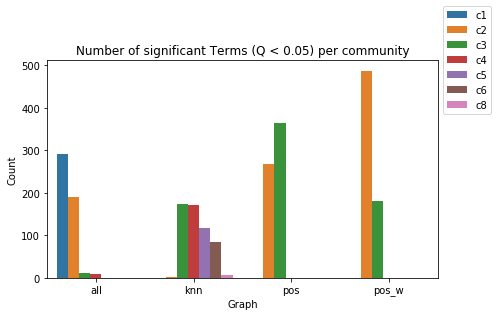

In [50]:
fig, ax = plt.subplots(figsize=(7, 4))
data_bars=pd.DataFrame(enriched_terms.groupby(['Graph','Comm'])['Term'].agg('count')).stack().reset_index().rename(columns={0:'Count'})
sns.barplot(x='Graph', y='Count', data=data_bars, hue='Comm')
ax.set_title('Number of significant Terms (Q < 0.05) per community')
ax.legend(loc='right', bbox_to_anchor=(1.15, 1));
plt.xticks(rotation=0)
plt.show()

Note that some of these communities are very big, which explains the big number of biological processes found above.

In [51]:
###Number of genes/community
# We skipped communities with <30 genes
get_community_table()[0].fillna(0).T

c1     c2     c3     c4     c5     c6     c7     c8
pos    908.0  579.0  482.0  119.0    9.0    3.0    2.0    0.0
pos_w  901.0  580.0  484.0  121.0   11.0    3.0    2.0    0.0
all    670.0  663.0  611.0  153.0    3.0    2.0    0.0    0.0
knn    449.0  343.0  315.0  314.0  253.0  217.0  110.0  101.0

In [52]:
pd.DataFrame(enriched_terms.groupby(['Graph','Comm'])['Term'].agg('count'))

Term
Graph Comm      
all   c1     290
      c2     191
      c3      12
      c4       9
knn   c2       1
      c3     174
      c4     171
      c5     116
      c6      84
      c8       6
pos   c2     267
      c3     365
pos_w c2     487
      c3     181

We can now find whether the Full Network, Positively associated, and Positively associated weighted, show any common terms among their biggest communities. We do not compare with kNN-G as this shows very homogeneous and different communities than the other two networks

In [53]:
#Finding consensus
temp=enriched_terms.copy()
temp['comm_term']=temp.Comm+'_'+temp.Term
temp=temp.loc[:,['Graph','comm_term']]

consensus=pd.DataFrame()
consensus=pd.concat([consensus, temp.loc[temp['Graph']=='pos']])
consensus=pd.merge(consensus,
                   temp.loc[temp['Graph']=='pos_w'], on="comm_term", how='outer', suffixes=['pos','pos_w'])
consensus=pd.merge(consensus, 
                   temp.loc[temp['Graph']=='all'], on="comm_term", how='outer').rename(columns={'Graph':'all'})

consensus=consensus.loc[consensus.isna().sum(1)==0].loc[:,['comm_term','Graphpos','Graphpos_w','all']]

Among the biggest communities we find several biological processes (55) that are simultaneously identified in the same community in the three graphs (`Full`, `Pos assoc`, and `Pos assoc weighted`).

In [54]:
consensus['comm']=[x[0] for x in consensus.comm_term.str.split('\_')]
consensus.groupby('comm')['comm_term'].agg('count')

comm
c2    76
c3    10
Name: comm_term, dtype: int64

**Questions**  
- Would you exclude any communities based on its size?
- Having identified these communities, how would you try to validate them?
- Would you now determine the relevant community to investigate further?


# Extracting communities

If you want to extract communities to use them in other sections.

In [55]:
#Requires running the community detection from the previous section
patlas=pd.read_csv('data/proteinatlas.tsv', sep="\t").loc[:,['Ensembl','Gene']]

In [56]:
#Compiles gene lists per community. We need Ensembl ids for further analyses
def get_ensembl():
    comm_counts=pd.DataFrame()
    gene_lists=pd.DataFrame()
    for i in [0,1,2,3]:
        graph=[pos_w,pos_w,all_u,knn][i]
        comm=[pos_comm,pos_w_comm,all_comm,knn_comm][i]
        name=['pos','pos_w','all','knn'][i]
        temp=pd.DataFrame(list(zip(graph.vs['name'],[x+1 for x in comm.membership]))).rename(columns={0:'gene',1:'community'})

        gl=pd.DataFrame(temp.groupby('community')['gene'].apply(list)).reset_index()
        gl['community']=['c'+str(i) for i in gl['community']]
        gl['network']=name
        gl=gl.loc[:,['network','community','gene']]
        gene_lists=pd.concat([gene_lists, gl])

    gene_communities=gene_lists
    gene_mat=pd.DataFrame()
    for net in gene_communities['network'].unique():
        temp=gene_communities.copy().loc[gene_communities['network']==net,]
        for comm in temp['community'].unique():
            gl=list(temp.copy().loc[temp['community']==comm,'gene'])[0]
            el=[patlas.loc[patlas['Gene']==x,'Ensembl'].iloc[0] for x in gl if x in patlas['Gene'].values]

            df=pd.DataFrame([net,comm,gl,el]).T
            df.columns=['network','community','Gene','Ensembl']
            gene_mat=pd.concat([gene_mat, df])
                
    return(gene_mat)

get_ensembl().to_csv('data/gene_communities.tsv', sep="\t", index=False)

# Conclusion

Here we've performed some network analyses based on a met-gene association network. We've explored different centrality measures to characterize the networks, and identified the communities of genes in these networks. We have also used gene set enrichment analysis to characterize these communities based on the genes, but it remains to show whether similar results would be attained if we considered the metabolites in each community.  